In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
test_phantom = phantom.Phantom.load(f'{parent}/assets/hand_phantom')

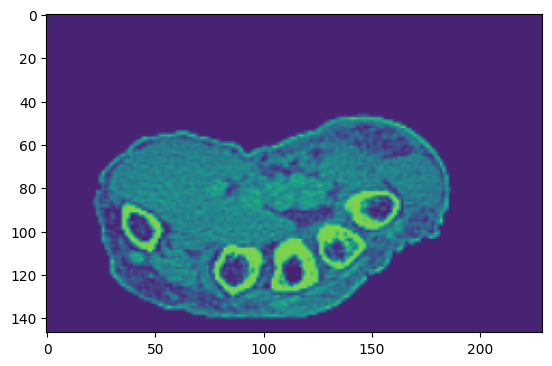

In [3]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)

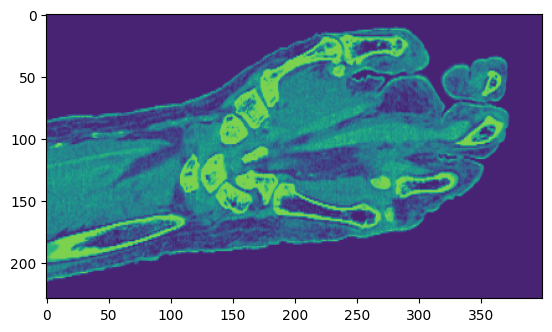

In [4]:
plt.imshow(test_phantom.get_complete()[0, 90, :, :], vmin=1500, vmax=2000)

In [5]:
num_transducers = 8
transducers = [transducer.Planewave(max_frequency=1.5e6,
                                    elements = 64, 
                                    width = 60e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/32,
                                    ray_num = 5, 
                                    imaging_ndims = 2,
                                    focus_elevation = 60e-3,
                                    ) for i in range(num_transducers)]

# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/6,
#                                     ray_num = 30, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 50e-3,
#                                     ) for i in range(num_transducers)]

# transducers = [transducer.Focused(max_frequency = 1e6,
#                                   elements = 128, 
#                                   width = 10e-3,
#                                   height =  10e-3,
#                                   sensor_sampling_scheme = 'not_centroid', 
#                                   sweep = np.pi/3,
#                                   ray_num = 16,
#                                   imaging_ndims = 2,
#                                   focus_azimuth = 60-3,
#                                   focus_elevation = 80-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [6]:
rotations = [geometry.Transform((r,0,0),(0,0,0)) for r in np.linspace(0, 2 * np.pi, num_transducers, endpoint=False)]
positions = [rot.apply_to_point((-0.07,0,0)) for rot in rotations]

for i in range(num_transducers):
    rotations[i].translation = positions[i]
    test_transducer_set.assign_pose(i, rotations[i])

In [7]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

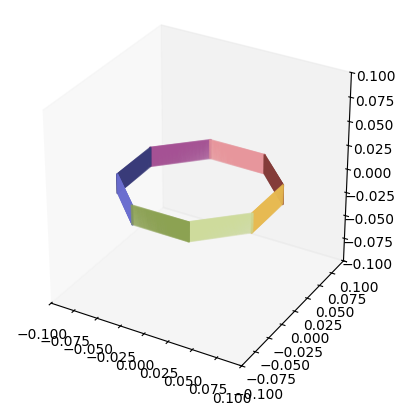

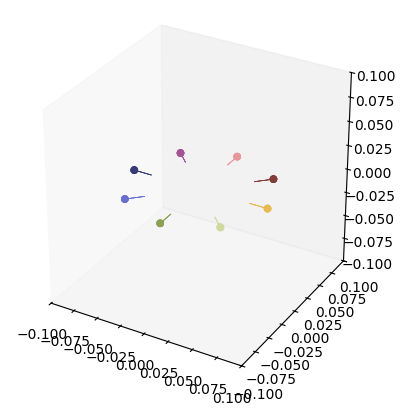

In [8]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [9]:
# simprops = simulation.SimProperties(
#                 grid_size   = (90e-3,20e-3,20e-3),
#                 voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
#                 PML_size    = (32,8,8),
#                 PML_alpha   = 2,
#                 t_end       = 12e-5,           # [s]
#                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
#                 alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
#                 alpha_power = 1.5,
#                 grid_lambda = 2,               # 
#                 )

simprops = simulation.SimProperties(
                grid_size   = (80e-3,120e-3,40e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [10]:
test_experiment = experiment.Experiment(
                 simulation_path = f'invitro_arm_experiment',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 5,
                 additional_keys = []
                 )

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


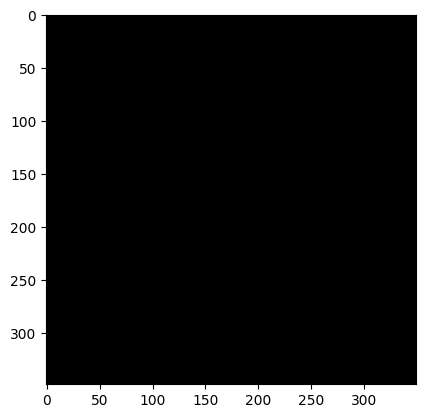

In [11]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 50])

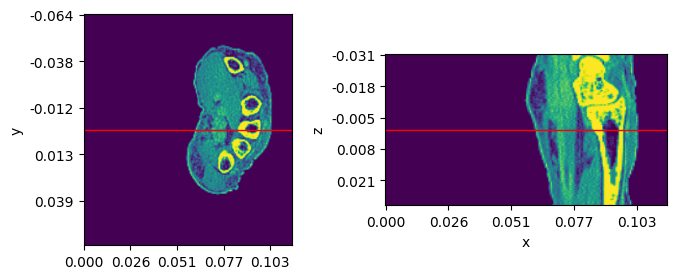

In [12]:
test_experiment.plot_ray_path(0)

In [13]:
test_experiment = experiment.Experiment.load('invitro_arm_experiment')
test_experiment.run(dry=True)

Number of simulation results (32) is less than the expected number of simulation results (40), are you sure the simulation finished running?
dry run of simulation


 88%|████████▊ | 7/8 [00:35<00:03,  3.82s/it]

In [ ]:
test_experiment.run(repeat=False)

running with 5 workers

preparation for sim   32 completed in 61.62 seconds
preparation for sim    8 completed in 62.66 seconds
preparation for sim   16 completed in 64.49 seconds
preparation for sim   24 completed in 73.03 seconds
preparation for sim   33 completed in 63.77 seconds
preparation for sim    9 completed in 65.35 seconds
preparation for sim   17 completed in 67.52 seconds
preparation for sim   25 completed in 74.96 seconds
simulation            32 completed in 141.57 seconds
simulation             8 completed in 140.24 seconds
simulation            16 completed in 139.69 seconds
simulation            24 completed in 140.57 seconds
preparation for sim   10 completed in 60.31 seconds
preparation for sim   34 completed in 61.69 seconds
preparation for sim   18 completed in 65.08 seconds
preparation for sim   26 completed in 72.41 seconds
simulation            33 completed in 141.60 seconds
simulation             9 completed in 140.16 seconds
simulation            17 completed

In [ ]:
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(test_experiment)

In [ ]:
images = test_reconstruction.compound(workers=24, resolution_multiplier=3, local=True, combine=False)

100%|██████████| 40/40 [00:00<00:00, 942540.22it/s]


1
local_image_matrix.shape (463, 691, 1)
starting distance loop
finished distance loop
starting interpolator
(319933, 3)
(319933,)
z:
(1169,)
[-0.09975    -0.09957889 -0.09940778 ...  0.09976556  0.09993667
  0.10010778]
finished interpolator
1
local_image_matrix.shape (447, 681, 1)
starting distance loop
finished distance loop
starting interpolator
(304407, 3)
(304407,)
z:
(1169,)
[-0.09975    -0.09957889 -0.09940778 ...  0.09976556  0.09993667
  0.10010778]
finished interpolator
1
local_image_matrix.shape (430, 670, 1)
starting distance loop
finished distance loop
starting interpolator
(288100, 3)
(288100,)
z:
(1169,)
[-0.09975    -0.09957889 -0.09940778 ...  0.09976556  0.09993667
  0.10010778]
finished interpolator
1
local_image_matrix.shape (447, 681, 1)
starting distance loop
finished distance loop
starting interpolator
(304407, 3)
(304407,)
z:
(1169,)
[-0.09975    -0.09957889 -0.09940778 ...  0.09976556  0.09993667
  0.10010778]
finished interpolator
1
local_image_matrix.shape (

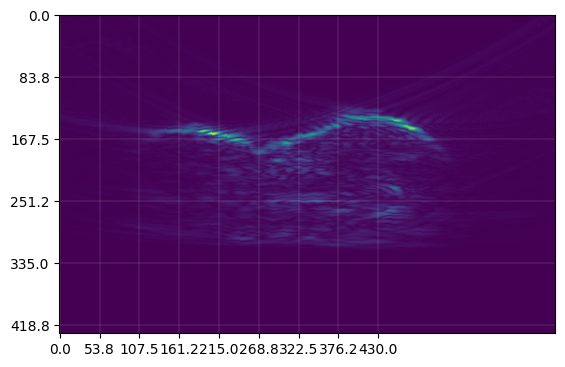

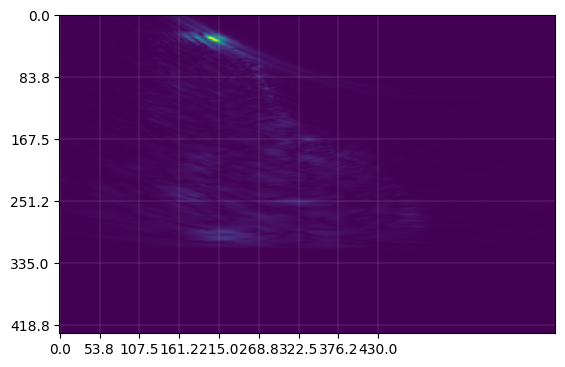

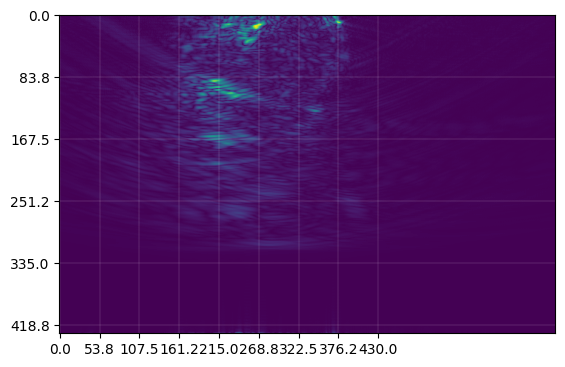

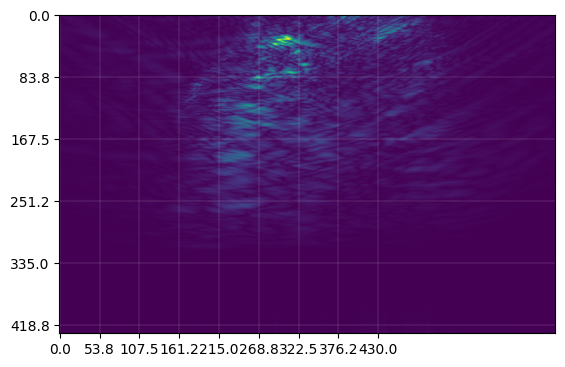

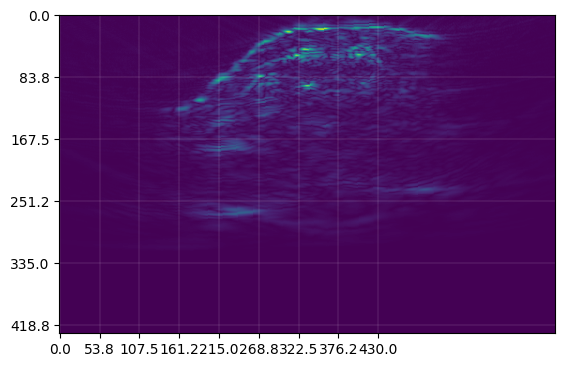

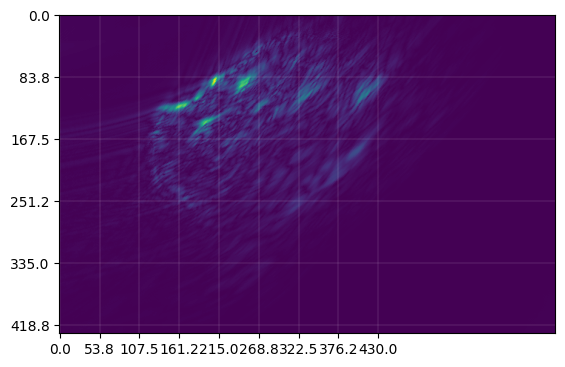

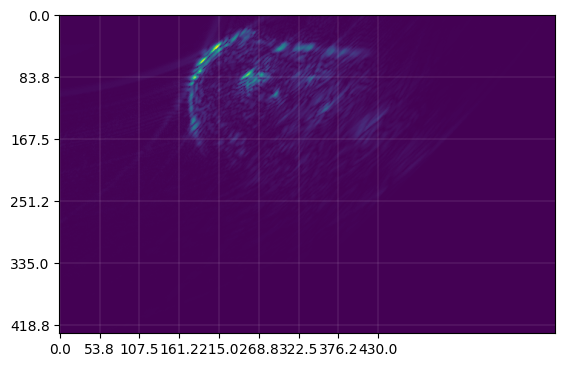

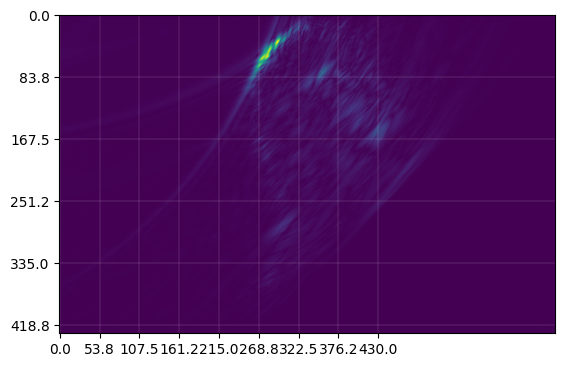

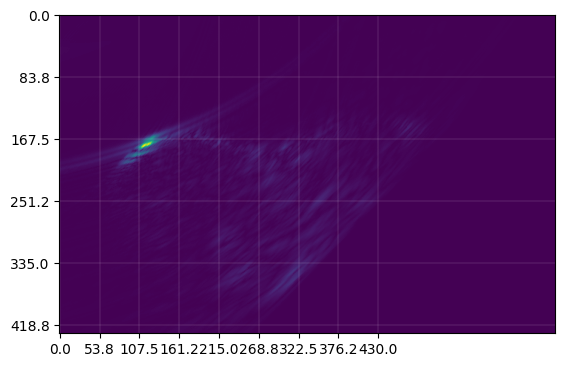

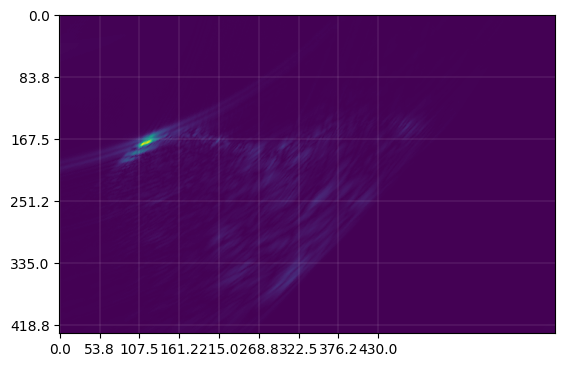

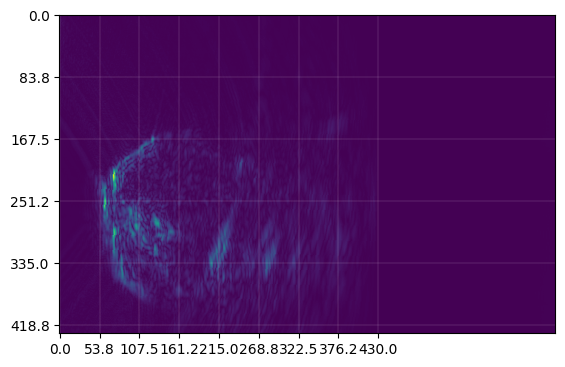

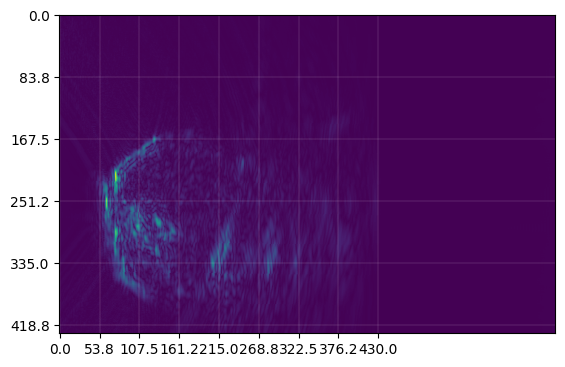

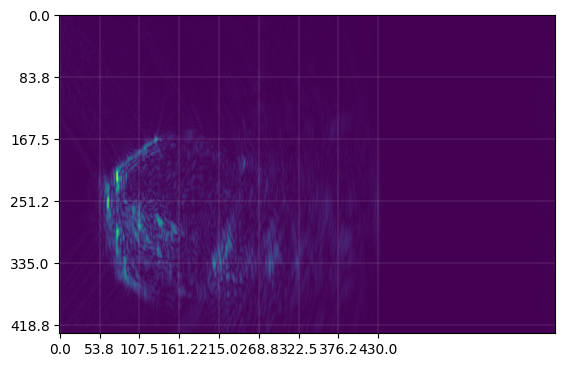

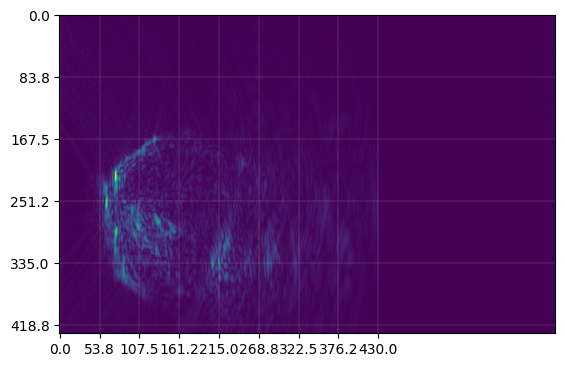

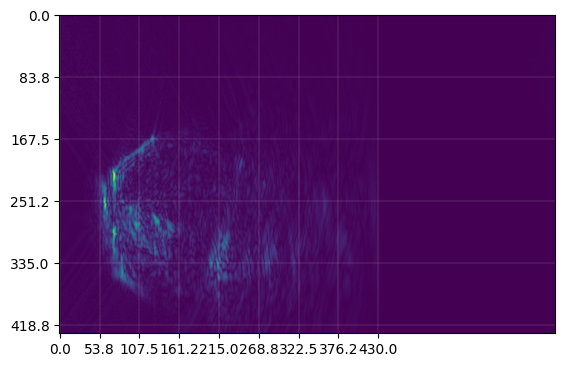

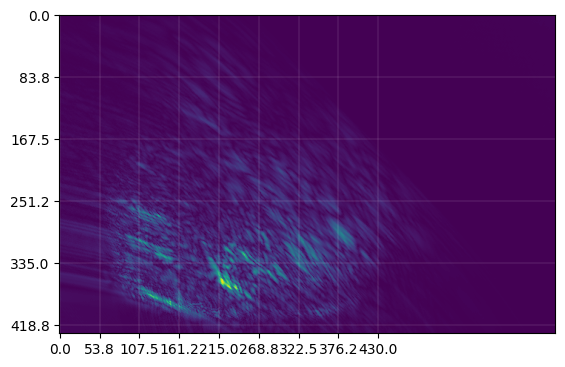

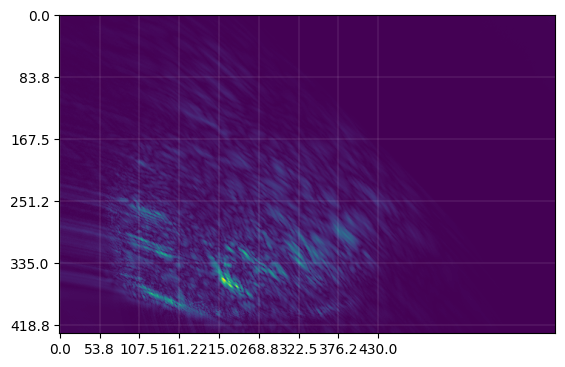

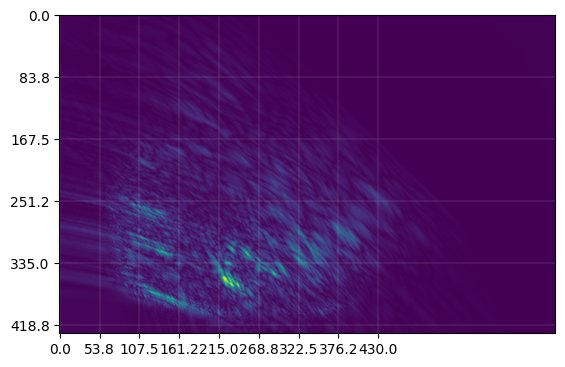

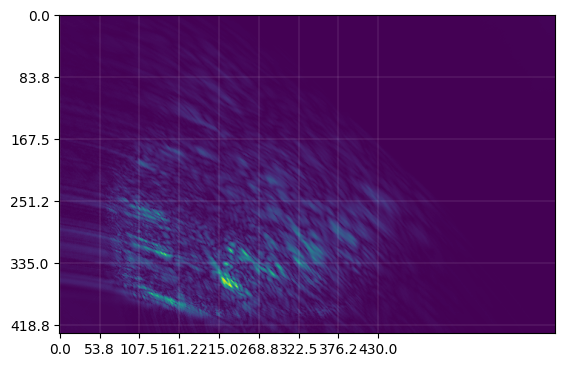

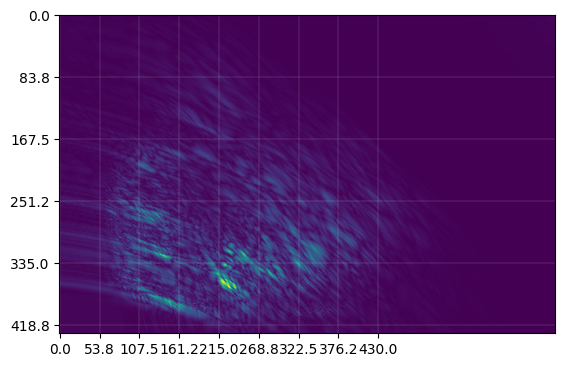

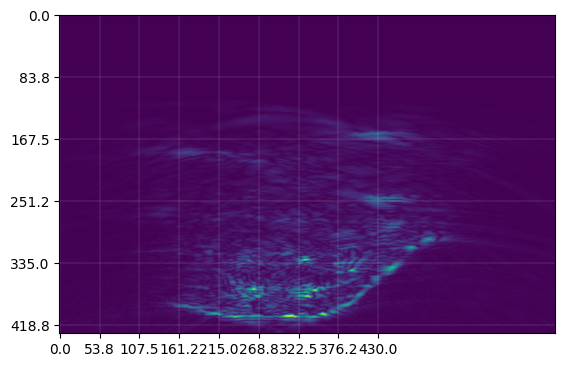

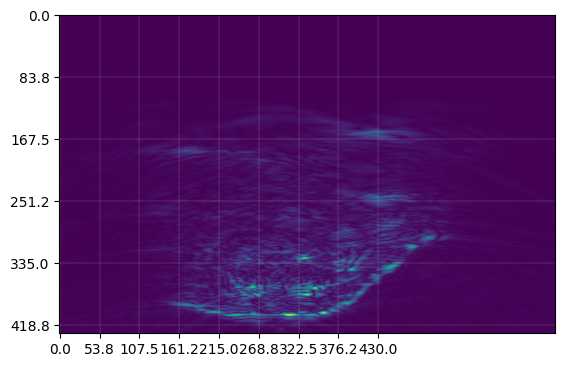

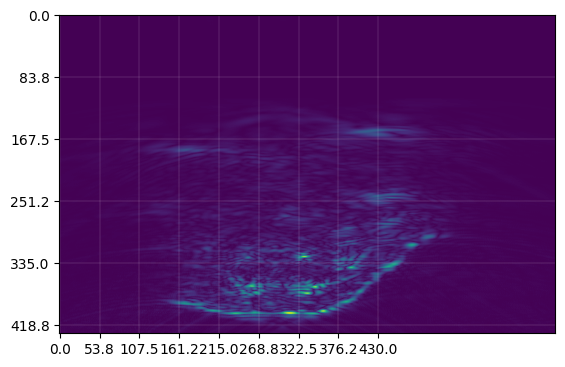

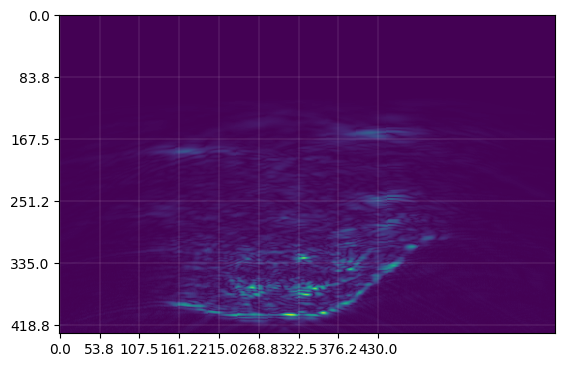

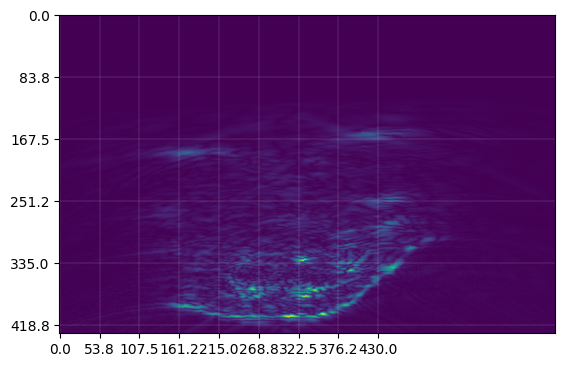

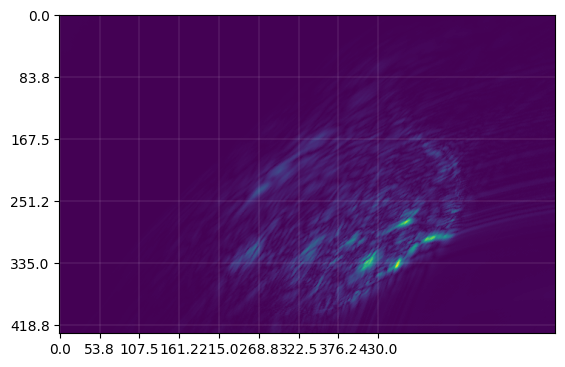

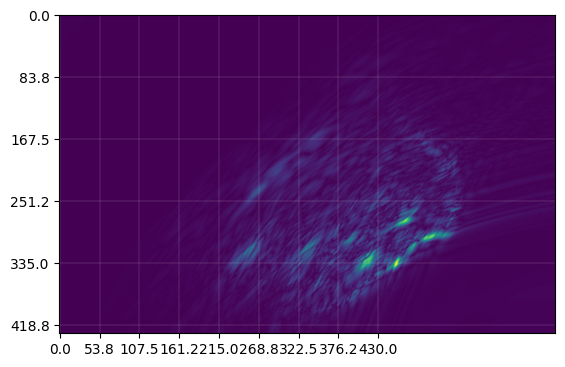

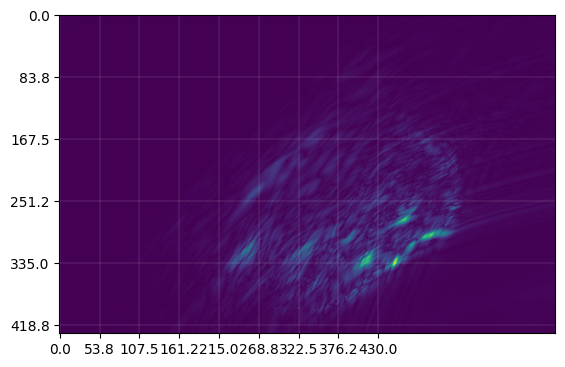

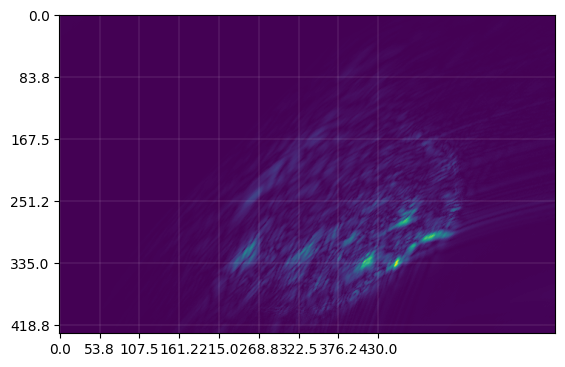

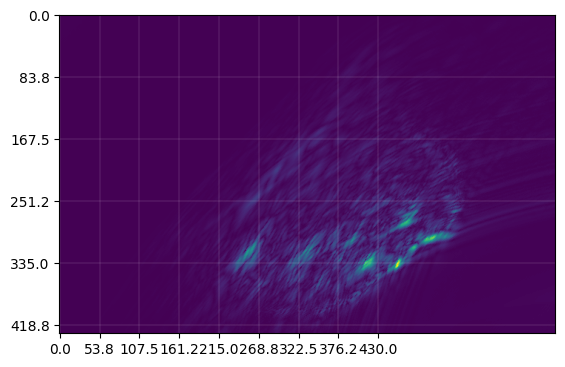

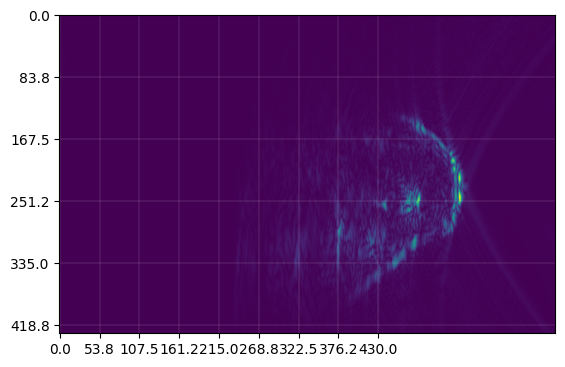

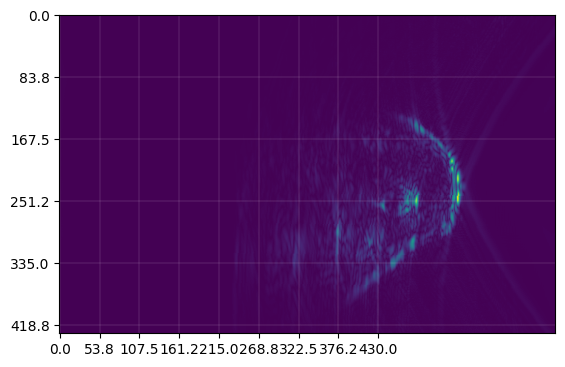

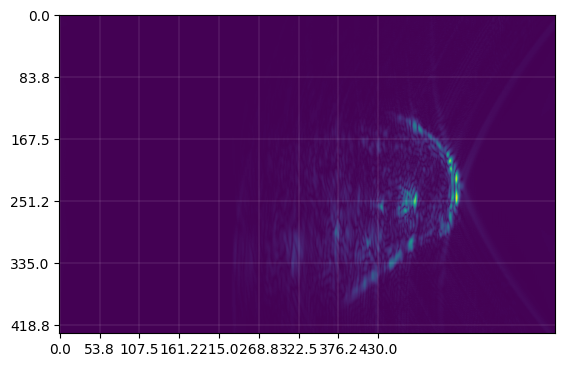

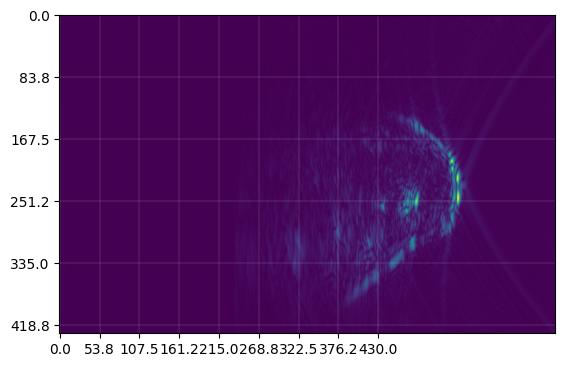

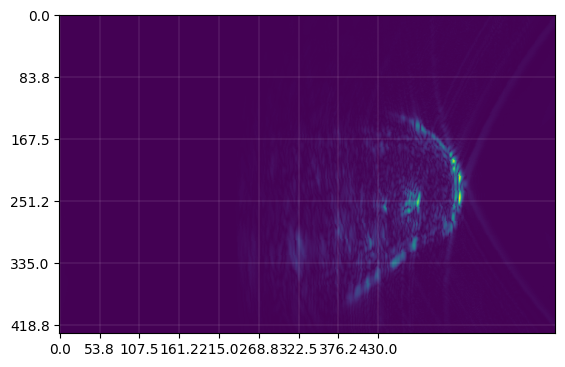

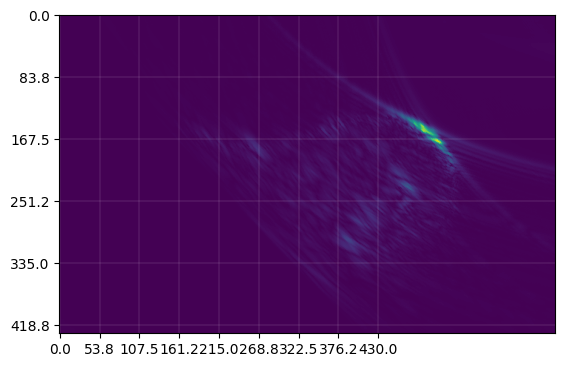

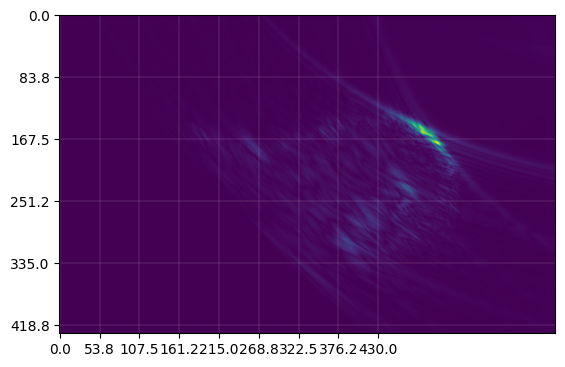

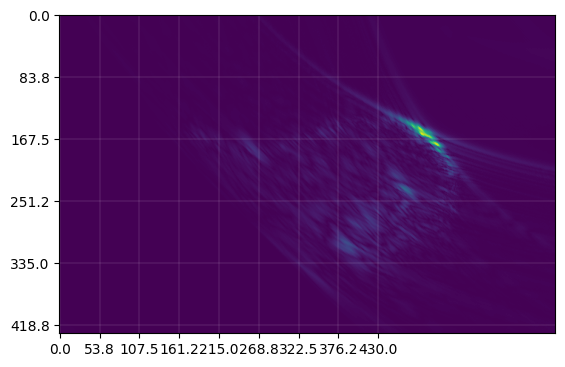

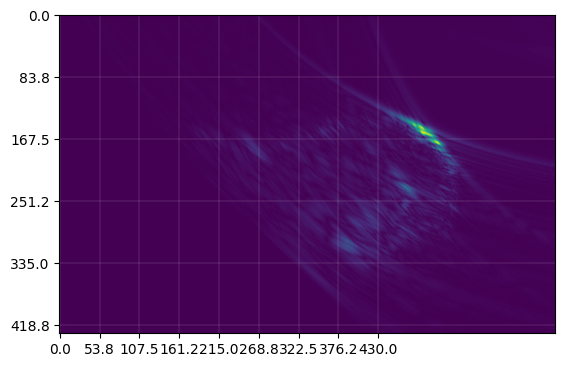

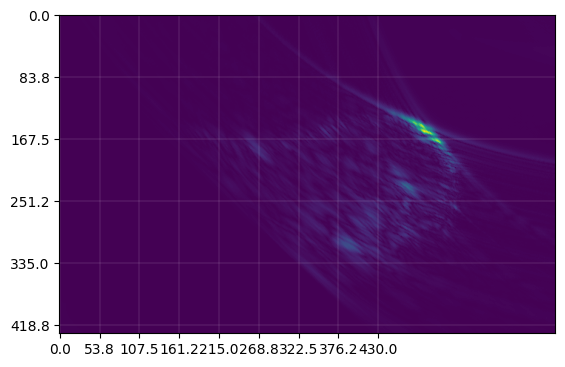

In [ ]:
for image in images:
    plt.xticks(np.linspace(0, image.shape[0],9))
    plt.yticks(np.linspace(0, image.shape[1],9))
    plt.imshow(image[:,:,image.shape[2]//2])
    plt.grid(color='w', linestyle='-', linewidth=0.1)
    plt.show()

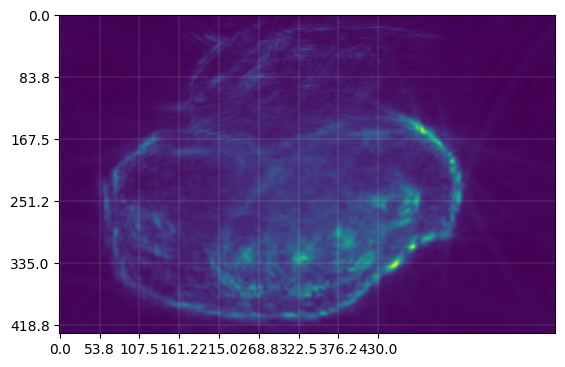

In [ ]:
plt.xticks(np.linspace(0, image.shape[0],9))
plt.yticks(np.linspace(0, image.shape[1],9))
plt.imshow(np.sum(images, axis=0)[:,:,image.shape[2]//2])
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

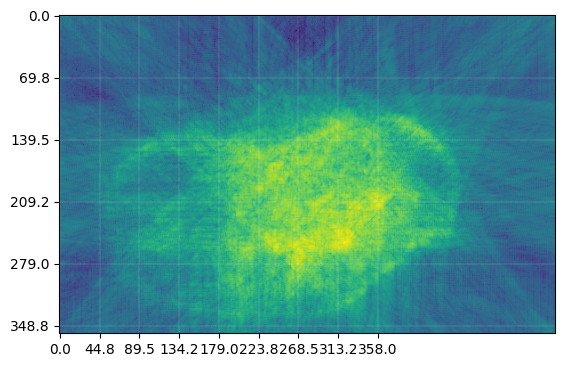

In [ ]:
plt.xticks(np.linspace(0, image.shape[0],9))
plt.yticks(np.linspace(0, image.shape[1],9))
plt.imshow(np.log(np.prod(images, axis=0))[:,:,image.shape[2]//2])
plt.grid(color='w', linestyle='-', linewidth=0.1)
plt.show()

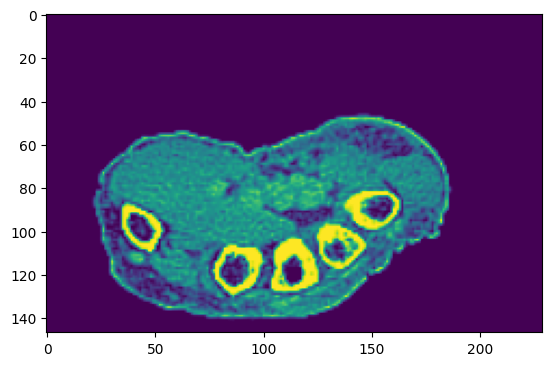

In [ ]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.get_complete().shape[3]//2])

In [ ]:
assert False

AssertionError: 

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

In [ ]:
fig, ax = plt.subplots(1, len(test_reconstruction.transducer_set), figsize=(20, 5))
for i in range(len(test_reconstruction.transducer_set)):
    ax[i].imshow(signals[i], vmin=0, vmax=200000)

In [ ]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)
plt.imshow(image, vmin=0, vmax=200000)

In [ ]:
plt.imshow(image, vmin=0, vmax=50000)


In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


In [ ]:
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)
# images = test_reconstruction.compound(workers=24, resolution_multiplier=1, local=True, combine=True)

In [ ]:
images.shape

In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200], vmin=1500, vmax=2000)


In [ ]:
plt.imshow(images[:, :, images.shape[2]//2])

In [ ]:
images.shape

In [ ]:
image = test_reconstruction.get_image(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200])


In [ ]:
plt.imshow(image)

In [ ]:
plt.plot(test_experiment.results[9][1][0])

In [ ]:
test_experiment.results[0][1][0]